In [40]:
# Import the necessary information
%store -r louisa_gdf site_dir data_dir

In [41]:
louisa_gdf

,Loc_Nm,geometry
28,Port Louisa National Wildlife Refuge,"MULTIPOLYGON (((-91.10656 41.13155, -91.10656 ..."
56,Port Louisa National Wildlife Refuge,"MULTIPOLYGON (((-91.10655 41.13335, -91.10657 ..."


In [42]:
### Import necessary packages
import earthaccess

### Reproducable file paths
import os
from glob import glob
import pathlib

### Managing spatial data
import geopandas as gpd
import xrspatial
import xarray as xr
import rioxarray
import rioxarray.merge as rxrmerge


### Managing other types of data
import numpy as np
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rmrm
from math import floor, ceil
import matplotlib.pyplot as plt
from rasterio.merge import merge as merge_arrays
from rasterio.enums import Resampling
from rasterio.transform import from_bounds
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rioxarray.merge import merge_arrays


### Manage invalid geometries
from shapely.geometry import MultiPolygon, Polygon

### Visualizing data
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

from math import floor, ceil
import matplotlib.pyplot as plt

import warnings

In [43]:
# Download elevation data
# Define data directory for 
louisa_elevation_dir = os.path.join(data_dir, 'louisa_elevation_strm')

os.makedirs(louisa_elevation_dir, exist_ok=True)

In [57]:
#  Define the URL template to download soil data from POLARIS
def soil_url_temp(variable='variable',
                  statistic='statistic',
                  depth='depth'):
    """
    Create a URL template for downloading soil data from POLARIS.

    Parameters
    ----------
    variable : str
        The soil `variable` of interest.
    statistic : {'mean', 'mode', 'p5', 'p50', 'p95'}
        The `statistic` type of interest.
    depth : {'0_5', '5_15', '15_30', '30_60', '60_100', or '100_200'}
        The `depth` of interest in cm.

    Returns
    -------
    soil_url_template : str
        Template of the URL to download the soil data.
    """
    soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
                    "v1.0"
                    f"/{variable}"
                    f"/{statistic}"
                    f"/{depth}"
                    "/lat{min_lat}{max_lat}"
                    "_lon{min_lon}{max_lon}.tif")
    return soil_url_template

In [58]:
# Define site bounds
def define_site_bounds(site_gdf):
    """
    Identify the bounds of a geographic site.
     
    Specifically, this function creates a tuple with
    a DataArray of the site bounds and the minimum longitude,
    minimum latitude, maximum longitude, and maximum latitude of a site.

    Parameters
    ----------
    site_gdf : GeoDataFrame
        The GeoDataFrame of the site of interest.

    Returns
    -------
    site_bounds : DataArray
        A DataArray with the minimum and maximum longitude and
        minimum and maximum latitude of the site.
    site_bounds_min_lon : float
        The minimum longitude of the site.
    site_bounds_min_lat : float
        The minimum latitude of the site.
    site_bounds_max_lon : float
        The maximum longitude of the site.
    site_bounds_max_lat : float
        The maximum latitude of the site.
    """
    site_bounds = (site_bounds_min_lon,
                   site_bounds_min_lat,
                   site_bounds_max_lon,
                   site_bounds_max_lat) = (
                       site_gdf
                       .total_bounds)
    return (site_bounds, site_bounds_min_lon, site_bounds_min_lat,
    site_bounds_max_lon, site_bounds_max_lat)

In [59]:
# Process soil DataArrays
def process_soil_da(site_soil_dir,
                    soil_url_template,
                    site_bounds,
                    site_bounds_min_lon,
                    site_bounds_min_lat,
                    site_bounds_max_lon,
                    site_bounds_max_lat,
                    variable='variable',
                    statistic='statistic',
                    depth='depth'):
    """
    Save, open, scale, and crop raster soil data.

    Parameters
    ----------
    site_soil_dir : str
        The directory where the soil data will be saved.
    soil_url_template : str
        Template of the URL to download the soil data.
    site_bounds : DataArray
        A DataArray with the minimum and maximum longitude and
        minimum and maximum latitude of the site.
    site_bounds_min_lon : float
        The minimum longitude of the site.
    site_bounds_min_lat : float
        The minimum latitude of the site.
    site_bounds_max_lon : float
        The maximum longitude of the site.
    site_bounds_max_lat : float
        The maximum latitude of the site.
    variable : str
        The soil `variable` of interest.
    statistic : {'mean', 'mode', 'p5', 'p50', 'p95'}
        The `statistic` type of interest.
    depth : {'0_5', '5_15', '15_30', '30_60', '60_100', or '100_200'}
        The `depth` of interest in cm.
Returns
    -------
    site_soil_das : list
        A list of DataArrays of soil data for the
        different rasters covering the site of interest.
    """
    site_soil_das = []
    # List out the soil files for download
    for min_lon in range(floor(site_bounds_min_lon),
                         ceil(site_bounds_max_lon)):
        for min_lat in range(floor(site_bounds_min_lat),
                             ceil(site_bounds_max_lat)):
            max_lon = min_lon + 1
            max_lat = min_lat + 1
            soil_url = soil_url_template.format(
                min_lat=min_lat,
                max_lat=max_lat,
                min_lon=min_lon,
                max_lon=max_lon)
            
            # Define file path for saving downloaded raster data
            soil_path = os.path.join(site_soil_dir,
                                     f"soil_{variable}_{statistic}_{depth}"
                                     f"_lat{min_lat}{max_lat}"
                                     f"_lon{min_lon}{max_lon}.tif")

            if not os.path.exists(soil_path):
                # Save raster data to soil path, mask and scale, squeeze
                soil_da = rxr.open_rasterio(
                    soil_url,
                    mask_and_scale=True
                    ).squeeze()
                soil_da.to_netcdf(soil_path)
                print(f'soil_da saved: {soil_path}')
            else:
                print(f'file already exists: {soil_path}')

            # Open and squeeze raster soil data
            soil_da = rxr.open_rasterio(
                soil_url,
                mask_and_scale=True
            ).squeeze()
            
             # Crop the raster soil data
            cropped_da = soil_da.rio.clip_box(*site_bounds)
            site_soil_das.append(cropped_da)
            print('Cropped')

    return site_soil_das

In [60]:
# Define data directory for the soil data
soil_sand_dir = os.path.join(data_dir, 'soil-sand')

os.makedirs(soil_sand_dir, exist_ok=True)

soil_sand_pattern = os.path.join (soil_sand_dir, '*.tif')
soil_sand_pattern

'/Users/erinzimmerman/earth-analytics/data2025/habitat_suitability/soil-sand/*.tif'

In [61]:
# Define Port Louisa bounds
louisa_bounds = define_site_bounds(louisa_gdf)

# Check bounds
louisa_bounds

(array([-92.50821646,  41.0953674 , -91.06802485,  41.96112543]),
 np.float64(-92.50821646103259),
 np.float64(41.095367397143676),
 np.float64(-91.0680248532639),
 np.float64(41.961125430459106))

In [62]:
# Create soil sand content url template
soil_url_template = soil_url_temp(variable='sand', statistic='mean', depth='60_100')

# Check url template
soil_url_template

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/60_100/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif'

In [63]:
# Process louisa soil pH DataArrays
louisa_soil_sand_indiv_das = process_soil_da(soil_sand_dir,
                                             soil_url_template,
                                             louisa_bounds[0],
                                             louisa_bounds[1],
                                             louisa_bounds[2],
                                             louisa_bounds[3],
                                             louisa_bounds[4],
                                             variable='sand',
                                             statistic='mean',
                                             depth='60_100')

file already exists: /Users/erinzimmerman/earth-analytics/data2025/habitat_suitability/soil-sand/soil_sand_mean_60_100_lat4142_lon-93-92.tif
Cropped
file already exists: /Users/erinzimmerman/earth-analytics/data2025/habitat_suitability/soil-sand/soil_sand_mean_60_100_lat4142_lon-92-91.tif
Cropped


In [64]:
# Merge Port Louisa Sand Files
louisa_soil_sand_da = merge_arrays(louisa_soil_sand_indiv_das)

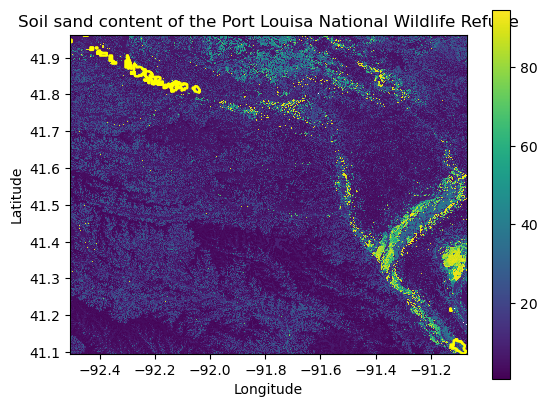

In [65]:
# Plot Port Louisa NWR on louisa_soil_sand_da
louisa_soil_sand_da.plot()
louisa_gdf.to_crs(louisa_soil_sand_da.rio.crs).boundary.plot(ax = plt.gca(), color='yellow')

# Add titles and axes to plot
plt.title('Soil sand content of the Port Louisa National Wildlife Refuge')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [66]:
# Define data directory for the louisa elevation data
louisa_elevation_dir = os.path.join(data_dir, 'louisa-elevation-srtm')

os.makedirs(louisa_elevation_dir, exist_ok=True)

louisa_elevation_dir

'/Users/erinzimmerman/earth-analytics/data2025/habitat_suitability/louisa-elevation-srtm'

In [67]:
# Log in to earthaccess
earthaccess.login()

# Search earthaccess datasets for SRTM
datasets = earthaccess.search_datasets(keyword='SRTM DEM')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
SRTMIMGM NASA Shuttle Radar Topography Mission Combined Image Data Set V003
SRTMIMGR NASA Shuttle Radar Topography Mission Swath Image Data V003
GFSAD30EUCEARUM

In [68]:
# louisa data search
louisa_srtm_pattern = os.path.join(louisa_elevation_dir, '*.hgt.zip')

# Define louisa elevation bounds
louisa_elev_bounds = tuple(louisa_gdf.total_bounds)

# Add buffer to Port Louisa elevation bounds
buffer = .025
louisa_xmin, louisa_ymin, louisa_xmax, louisa_ymax = louisa_elev_bounds
louisa_elev_bounds_buffer = (louisa_xmin-buffer,
                               louisa_ymin-buffer,
                               louisa_xmax+buffer,
                               louisa_ymax+buffer)

if not glob(louisa_srtm_pattern):
    # Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
    louisa_srtm_search = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=louisa_elev_bounds_buffer
    )
    # Download SRTM files
    louisa_srtm_results = earthaccess.download(
        louisa_srtm_search,
        louisa_elevation_dir)
else:
    print('SRTM files already downloaded')

# Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
louisa_srtm_search = earthaccess.search_data(
    short_name='SRTMGL1',
    bounding_box=louisa_elev_bounds_buffer
)
# Download SRTM files
louisa_srtm_results = earthaccess.download(
    louisa_srtm_search,
    louisa_elevation_dir)

# Check louisa_srtm_results download
# srtm dataset files are geotiffs but they instead have a .hgt tag (height)
# results are also .zip files
louisa_srtm_results

SRTM files already downloaded


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

['/Users/erinzimmerman/earth-analytics/data2025/habitat_suitability/louisa-elevation-srtm/N41W093.SRTMGL1.hgt.zip',
 '/Users/erinzimmerman/earth-analytics/data2025/habitat_suitability/louisa-elevation-srtm/N41W092.SRTMGL1.hgt.zip']

In [69]:
# Open Port Louisa SRTM files
louisa_srtm_da_list = []
for srtm_path in glob(louisa_srtm_pattern):
    # Open files and put them in a DataArray
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    # Crop DataArrays
    srtm_cropped_da = tile_da.rio.clip_box(*louisa_elev_bounds_buffer)
    louisa_srtm_da_list.append(srtm_cropped_da)

In [70]:
# Merge tiles
louisa_srtm_da = merge_arrays(louisa_srtm_da_list)

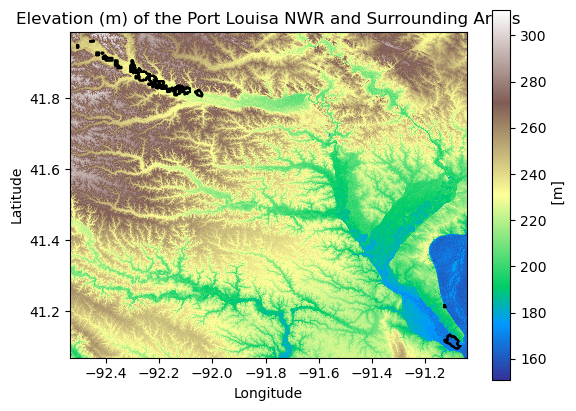

In [71]:
# Check SRTM data w/ Port Louisa plotted on top
louisa_srtm_da.plot(cmap='terrain')

louisa_gdf.boundary.plot(ax = plt.gca(), color='black')
plt.title('Elevation (m) of the Port Louisa NWR and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [53]:
# Store the essential information to import into the next notebook
%store louisa_gdf louisa_srtm_da

Stored 'louisa_gdf' (GeoDataFrame)
Stored 'louisa_srtm_da' (DataArray)
